# DSPN Final Project: 

## Characterization of noise in synthetic block design fNIRS data with linear regression

### Timothy Nolan

**DUE:** 12pm EST, May 2, 2022

---
## 2. Background

Near-Infrared Spectroscopy (NIRS) is a diffuse optical imaging (DOI) method using red to near-infrared lasers or light emitting diodes (LEDs), corresponding to wavelengths 600-1000 nm on the electromagnetic spectrum. As a neuroimaging tool, functional NIRS (fNIRS) seeks to measure regional changes in cortical oxygen consumption across one or more experimental tasks by coupling light sources and detectors to the scalp. Light transmitted from the sources diffuses through the scalp, skull, cerebrospinal fluid, and the first 5 to 8mm of cortical tissue; some light scatters back and is sensed by the detectors on the scalp. Changes in optical absorption of the underlying tissues over time results in fluctuations to the detected light intensity. These fluctuations are a result of the brain’s hemodynamic response, changes to cortical oxy- and deoxyhemoglobin (HbO and HbR, respectively) concentrations due to the cortex’s changing metabolic demands over time.

Functionally evoked changes to cortical oxygen consumption measured by fNIRS are shown to be related to the blood oxygen level dependent (BOLD) signal of functional magnetic resonance imaging (fMRI)<sup>1</sup>. As a consequence, fNIRS data are often analyzed with regression techniques originally implemented in fMRI, popularized in the late 90s and early 00s and labeled *Statistical Parametric Mapping* by Karl Friston<sup>2</sup>. At a coarse level, we regress our *n* channel hemodynamic time series data, $Y_{Hb}$ onto a task's experimental design matrix (which has been convolved with the canonical fNIRS hemodynamic response funtion), $X_{HRF}$. **Here, I solve the regression models with ordinary least squares (OLS) and the fNIRS-specific generalized linear model, autoregressive iteratively reweighted least squares (AR(P)-IRLS) solutions.**

Huppert and colleagues developed the NIRS Brain AnalyzIR Toolbox, a MATLAB software package for fNIRS analysis which we now simply call *nirs-toolbox* <sup>3</sup> and you can find on [GitHub](https://github.com/huppertt/nirs-toolbox). In addition to standardizing fNIRS analysis methods, like the generalized linear model, *nirs-toolbox* is equipped with a suite of functions to generate synthetic NIRS data to a user's specification. Despite providing this tool to the public, there is no thorough/systematic "guide" on its usage, so to speak, and how modifying simulation parameters -- `noise` and `beta`, in particular -- affects the synthetic data.

### fNIRS linear regression models

The $N$-channel stimulus-evoked oxy- and deoxyhemoglobin NIR response function, $Y_{\Delta[Hb]} \in R^{T×N}$ is a measure of relative hemoglobin change from baseline to task, $\Delta[Hb]$, and can be modeled as a first-order ordinary least squares (OLS) model described by the equation

$$Y_{Hb}=X_{HRF}*\beta+\epsilon$$

where $X_{HRF} \in R^{T×2}$ is the stimulus design matrix (plus a column of 1s to account for baseline offset), and $\beta \in R^{2×N}$ are the regression coefficients (plus a row of 1s for the same reason) which represent the neural activation for a given channel due to the task, and $\epsilon \in R^{T×1}$ is the residual error.

FNIRS data violate OLS assumptions, in particular, no autocorrelation (fNIRS, like other time series, are autocorrelated) and normally distributed residuals (fNIRS data are heavy-tailed). *P*-th order autoregressive, iteratively reweighted least squares, AR(P)-IRLS, is the fNIRS generalized linear model, described by the equation

$$S*W*Y_{Hb}=S*W*X_{HRF}*\beta+\varepsilon$$

where $S \in R^{N×N}$ is the Huber bisquare reweighting matrix to downweight outliers, $W \in R^{N×N}$ is the pre-whitening matrix to remove autocorrelation, and $\varepsilon \in R^{T×1}$ are the *innovations*. See ref<sup>4</sup> for more details.

---
## 3. Variables

### fNIRS time series data

One can generate synthetic fNIRS data with the *nirs-toolbox* by providing the `nirs.testing.simData` function ([GitHub link](https://github.com/huppertt/nirs-toolbox/blob/master/%2Bnirs/%2Btesting/simData.m)) with some raw noise data, `noise`, stimulus design, `stim`, the signal scale factor (relative to $\sigma_{noise}$), `beta`, and the channels where a *true* relationship is to be modeled, `channels`.

Here, I generate synthetic data generated under four different noise assumptions: IID, AR(5), sinusoidal, and "physiological" (AR(5) + sinusoidal), yielding $Y_{IID}$, $Y_{AR(5)}$, $Y_{SIN}$, and $Y_{PHYS}$.

All $Y$ data are 32 channels (where successive channels are HbO and HbR data from the same source-detector pair), recorded at a sampling frequency of 5Hz, generated under the same experimental design, `stim` function: one single, block design task, with 30s blocks of rest interleaved with 30s blocks of some task 'A.' This forms one common experimental design matrix, $X_{HRH}$. Two hours of data were recorded, totaling 120 blocks. The *true* signal added atop the `noise` is determined by `beta`. Here, we define `beta` as follows:

`beta` = [0.1, 0.1, 0.5, 0.5, 1, 1, 2, 2, 3, 3, ... , 10, 10, 0, 0, 0, 0, 0, 0, 0, 0]; is a 1x32 matrix describing the *true* signal in a given channel. That is, suppose our signal-to-noise ratio (SNR) ranges from 0.1 to 10 for each of the first 12 successive source-detector pairs, then 0 (i.e. no true relationship) for the remaining 4x2=8 channels. Also note that for some given channel, the deoxyhemoglobin response, $\beta_{HbR}$, is generally $-\frac{\beta_{Hb0}}{2}$ experimentally, so `nirs.testing.simData` halves the betas at the even indices of the above array, so it's 0.1, -0.05, 0.5, -0.25, ....

While one is naturally inclined to think `beta` is/are the regression coefficient(s) solutions, it's a bit of a misnomer, as this `beta` and the associated time series go through a series of nonlinear transformations that obfuscate this classical notion of `beta`.

How, then, do the different types of `noise` and levels of `beta` change our regression, bootstraps, and power? Here's the first two minutes of time series data for each noise type, and for `beta`= 0.1, 1.0, 10.0:

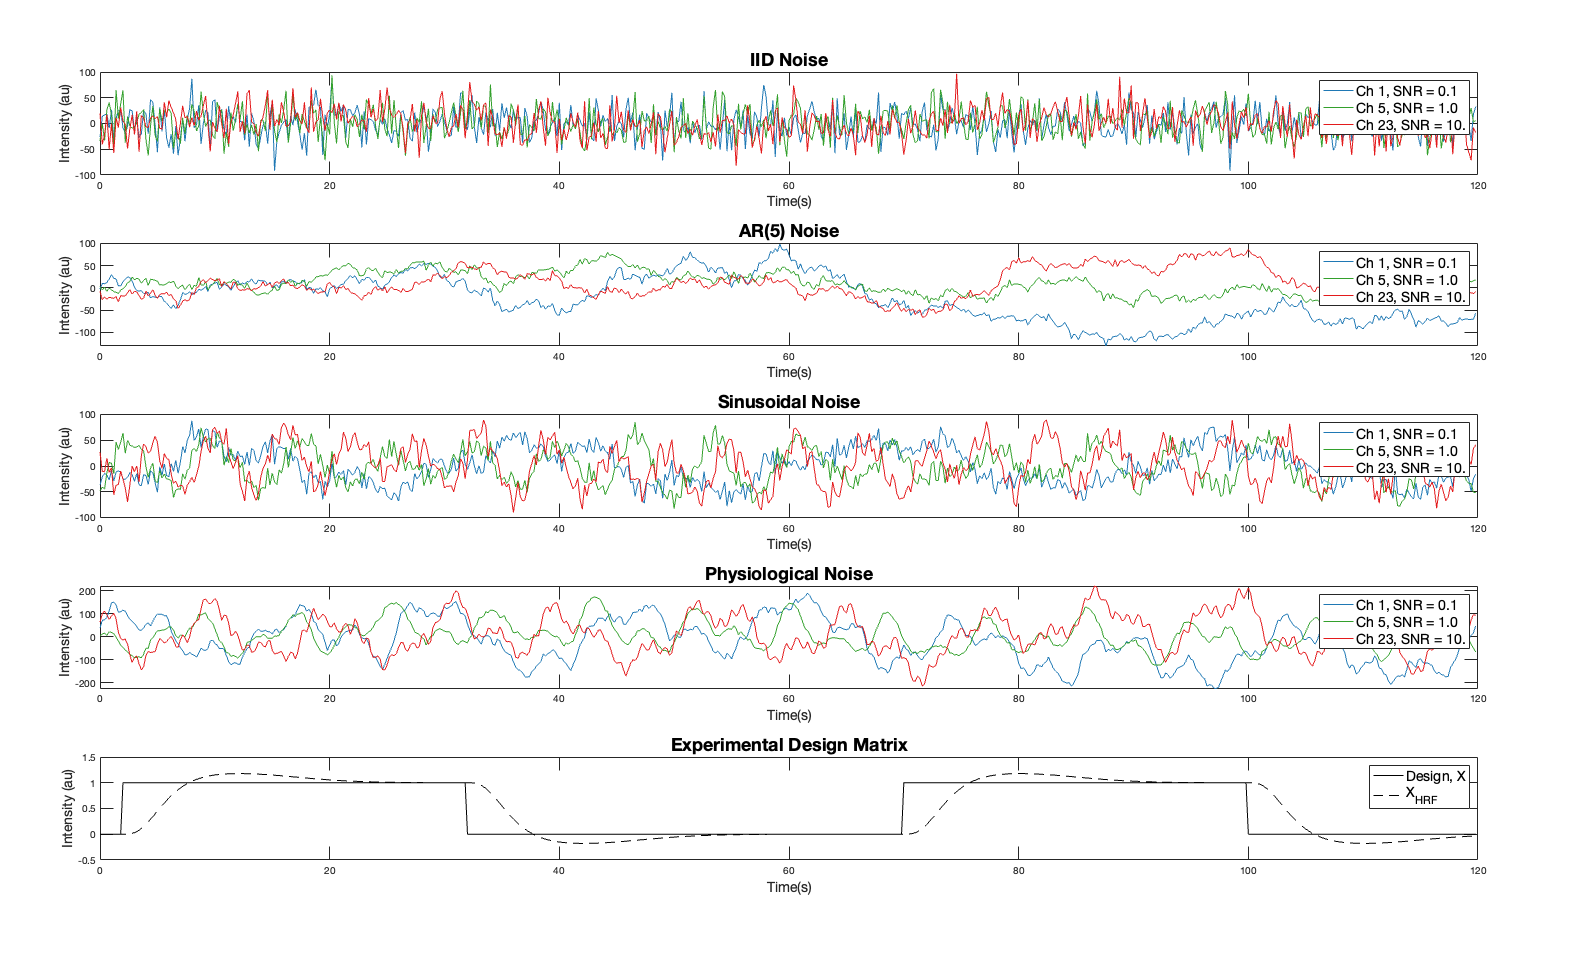

In [220]:
library("IRdisplay")

display_png(file="./images/hbtimeseries.png")  

### Data

My most sincere apologies, but data were generated using MATLAB and the *nirs-toolbox*. Much as I'd love to, I didn't have time to re-write *nirs-toolbox* in Python or R. That said, refer to `MakeDataSets.m` (lightly commented) and the toolbox if you are wondering about the data generation procedure.

When all is said and done, the 4 different noise types are imported into this jupyter notebook as two separate matrices (= 8 total):

1. OLS 36000x33 Hb data frames; that's $36000 = 2h * 60 min/h * 60 sec/min * 5 Hz$, 32 channels of $Y$ data, and 1 column of $X$ data. 
2. AR(5)-IRLS 36000x64 residual data frames, as $X$ is specifically weighted to each channel of $Y$ data (see above prewhitening).

---
## 4. Hypotheses

I hypothesize the following:

1. For a given `beta`, the magnitude of our regression coefficients will decrease as complexity of the noise increases $\beta_{IID} > \beta_{SIN} > \beta_{AR(5)} > \beta_{PHYS}$.
2. For a given noise type, as `beta` increases, we see decreases to our regression coefficients and corresponding p-values, but crucially, this mapping is *not* one-to-one. That is, if `beta` increases by 1, this will not yield a regression coefficient increase by 1.
3. Power analysis will show coverage is inversely proportional to `beta`.

---
## 5. Data Organization

### Importing into jupyter

We import the following four 36000x33 \*.mat files:
1. $NIRS_{IID,raw}$
2. $NIRS_{AR,raw}$
3. $NIRS_{SIN,raw}$
4. $NIRS_{PHYS,raw}$

where `df.1` through `df.32` are channels $Y_1$ through $Y_{32}$, and `df.33` corresponds to $X_{HRF}$.

We import the following four 36000x64 \*.mat files:
1. $NIRS_{IID,resid}$
2. $NIRS_{AR,resid}$
3. $NIRS_{SIN,resid}$
4. $NIRS_{PHYS,resid}$

where `df.1` through `df.32` are channels $Y_1$ through $Y_{32}$, and `df.33` through `df.64` corresponds to $X_{1,HRF}$ through $X_{32,HRF}$. 

In [221]:
cat("Raw data = 36000x33")
colnames(nirs_iid_raw)

cat("Residuals data = 36000x64")
colnames(nirs_iid_resid)

Raw data = 36000x33

[1] "df.1"  "df.2"  "df.3"  "df.4"  "df.5"  "df.6"  "df.7"  "df.8"  "df.9" 
[10] "df.10" "df.11" "df.12" "df.13" "df.14" "df.15" "df.16" "df.17" "df.18"
[19] "df.19" "df.20" "df.21" "df.22" "df.23" "df.24" "df.25" "df.26" "df.27"
[28] "df.28" "df.29" "df.30" "df.31" "df.32" "df.33"

Residuals data = 36000x64

[1] "df.1"  "df.2"  "df.3"  "df.4"  "df.5"  "df.6"  "df.7"  "df.8"  "df.9" 
[10] "df.10" "df.11" "df.12" "df.13" "df.14" "df.15" "df.16" "df.17" "df.18"
[19] "df.19" "df.20" "df.21" "df.22" "df.23" "df.24" "df.25" "df.26" "df.27"
[28] "df.28" "df.29" "df.30" "df.31" "df.32" "df.33" "df.34" "df.35" "df.36"
[37] "df.37" "df.38" "df.39" "df.40" "df.41" "df.42" "df.43" "df.44" "df.45"
[46] "df.46" "df.47" "df.48" "df.49" "df.50" "df.51" "df.52" "df.53" "df.54"
[55] "df.55" "df.56" "df.57" "df.58" "df.59" "df.60" "df.61" "df.62" "df.63"
[64] "df.64"

In [222]:
head(nirs_iid_raw)

,df.1,df.2,df.3,df.4,df.5,df.6,df.7,df.8,df.9,df.10,⋯,df.24,df.25,df.26,df.27,df.28,df.29,df.30,df.31,df.32,df.33
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-40.1162960,7.3852987,1.058331,-19.0733667,-48.156889,0.9233894,-31.882615,9.8372603,-26.40880,-2.387279,⋯,-2.1218987,-32.176978,1.927035,-28.815043,7.00970912,-24.186499,-26.103222,7.045602,-9.4065778,0
2,-35.4561179,-4.8110955,-24.319933,-13.4538995,-2.250879,-15.0670420,-7.714182,-0.7210604,-40.39037,-8.694988,⋯,1.0761392,-8.646282,-2.514120,2.437391,-0.04250002,-35.184803,-19.228490,20.603357,-16.5891623,0
3,-1.8693905,4.2321282,28.682051,-6.5598795,13.567153,-11.6600680,-54.674187,11.6832968,-25.88591,16.097338,⋯,4.5303170,-19.990379,-1.771364,-4.883587,-18.62498657,-12.299941,12.914647,-49.361410,0.1024458,0
4,7.3343624,15.0561241,27.897170,-14.5808356,4.682526,-19.8029180,-14.272176,1.6978239,22.54631,17.266047,⋯,10.0316389,32.597685,-19.559124,-15.111355,5.89812815,18.141366,-3.460688,25.023458,-12.9790391,0
5,-0.7562331,-0.3771789,-2.179013,0.7015013,-39.284646,10.2916870,-17.823342,13.8293010,14.22700,-16.934935,⋯,7.1630501,-12.399542,-13.412767,1.136508,4.20666040,-19.129556,3.813931,44.436769,5.2600089,0
6,-4.4289579,-0.6490131,4.334218,-18.0248636,-24.717468,-16.3958218,-59.551945,15.1694424,19.86602,-15.437488,⋯,0.7413656,8.348159,-38.395139,-10.986022,-5.73396423,2.306785,-21.781676,-37.878437,6.7428772,0


While convention may be to rename $Y$s and $X$s, I actually like this auto matrix naming convention for easy coding, so rather than fuss with it I keep it as is. Plots will always clarify and X's and Y's!

In [223]:
#install.packages("R.matlab")
library("R.matlab")

nirs_iid_raw <- data.frame(readMat('./data/y_iid_raw.mat'))

nirs_iid_resid <- data.frame(readMat('./data/y_iid_resid.mat'))

nirs_ar_raw <- data.frame(readMat('./data/y_ar_raw.mat'))

nirs_ar_resid <- data.frame(readMat('./data/y_ar_resid.mat'))

nirs_sin_raw <- data.frame(readMat('./data/y_sin_raw.mat'))

nirs_sin_resid <- data.frame(readMat('./data/y_sin_resid.mat'))

nirs_phys_raw <- data.frame(readMat('./data/y_sinar_raw.mat'))

nirs_phys_resid <- data.frame(readMat('./data/y_sinar_resid.mat'))

In [224]:
library(tidyverse)

In [225]:
install.packages("latex2exp")

Installing package into ‘/opt/homebrew/lib/R/4.1/site-library’
(as ‘lib’ is unspecified)



---
## 6. Analysis

### Class Method 1: Regression: OLS and AR(P)-IRLS

#### Ordinary Least Squares (OLS)

In [226]:
nirs_ols <- function(dat) {
    
    X <- dat[,33]

    Y <- dat[,1:32]
    
    numvar = ncol(Y)
    
    beta <- matrix(0,nrow=numvar) 
    
    for (i in 1:numvar) {
        
        fit <- lm(Y[,i] ~ X)
        
        beta[i,] <- coef(fit)[2]
   }
    
    return(data.frame(beta))
}

beta_TRUTH <- c(0.1,-0.05,0.5,-0.25,1,-0.5,2,-1,3,-1.5,4,-2,5,-3.5,6,-3,7,-3.5,8,-4,9,-4.5,10,-5,0,0,0,0,0,0,0,0)

beta_iid_raw <- nirs_ols(nirs_iid_raw)
beta_ar_raw <- nirs_ols(nirs_ar_raw)
beta_sin_raw <- nirs_ols(nirs_sin_raw)
beta_phys_raw <- nirs_ols(nirs_phys_raw)

idx = 1:nrow(beta_iid_raw)
dat <- data.frame(idx,beta_TRUTH,beta_iid_raw,beta_ar_raw,beta_sin_raw,beta_phys_raw)
colnames(dat) <- c('idx','beta_TRUTH','beta_IID','beta_AR','beta_SIN','beta_PHYS')
dat

idx,beta_TRUTH,beta_IID,beta_AR,beta_SIN,beta_PHYS
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.10,0.43677356,2.3680287,0.717498082,1.98317176
2,-0.05,-0.08424266,-0.8660392,-0.265170099,0.11204912
3,0.50,1.00883927,-3.7981216,0.940067745,-4.11091899
4,-0.25,-0.37784799,0.4928422,-0.448563772,0.56811427
5,1.00,2.12733306,0.7854662,2.277711045,0.90390719
6,-0.50,-0.76812306,-0.1196323,-0.828293051,-0.03262207
7,2.00,3.89576803,4.8184835,3.414202759,4.61399758
8,-1.00,-1.98293314,-2.9728602,-2.164525872,-3.14091314
9,3.00,5.76898459,5.6636546,6.022305976,5.06692575


In [ ]:
beta_iid_raw

,idx,NoiseType,beta
,<int>,<chr>,<dbl>
1,1,TRUTH,0.10
2,2,TRUTH,-0.05
3,3,TRUTH,0.50
4,4,TRUTH,-0.25
5,5,TRUTH,1.00
6,6,TRUTH,-0.50


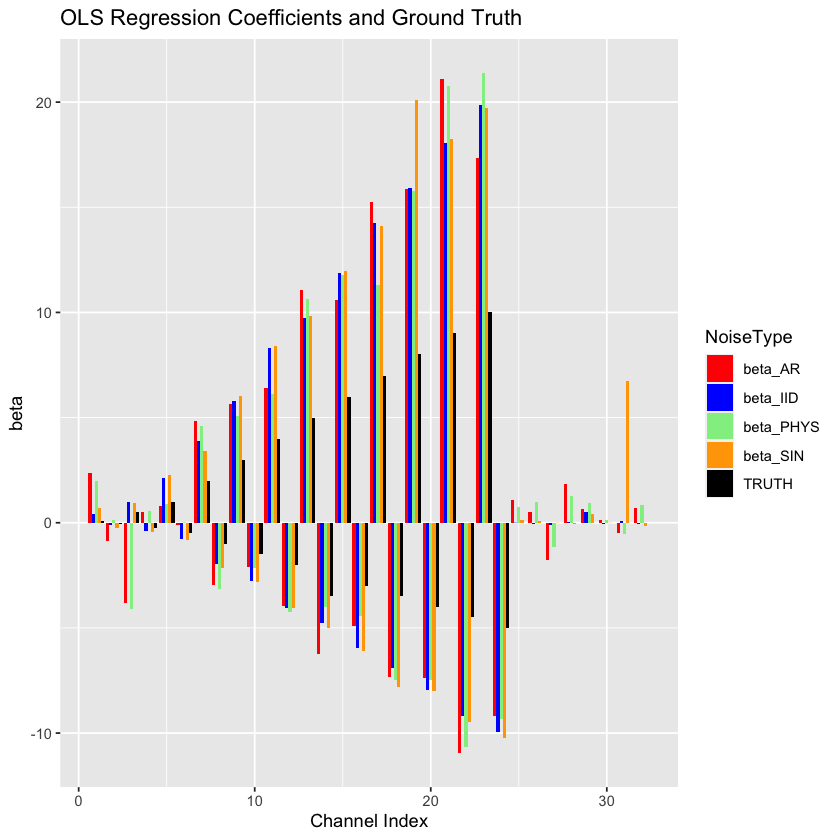

In [240]:
df <- gather(dat, key="NoiseType", value="beta", 2:6)
head(df)

ggplot(data = df, aes(x = idx, y = beta, fill = NoiseType)) +
    geom_col(position="dodge") +
    scale_fill_manual(values=c("red","blue","lightgreen","orange","black"))+
    xlab("Channel Index")+
    ggtitle("OLS Regression Coefficients and Ground Truth")

In [228]:
colnames(dat)[2] <- c('TRUTH')
df2 <- gather(dat, key="NoiseType", value="beta", 3:6)
head(df2)

,idx,TRUTH,NoiseType,beta
,<int>,<dbl>,<chr>,<dbl>
1,1,0.10,beta_IID,0.43677356
2,2,-0.05,beta_IID,-0.08424266
3,3,0.50,beta_IID,1.00883927
4,4,-0.25,beta_IID,-0.37784799
5,5,1.00,beta_IID,2.12733306
6,6,-0.50,beta_IID,-0.76812306


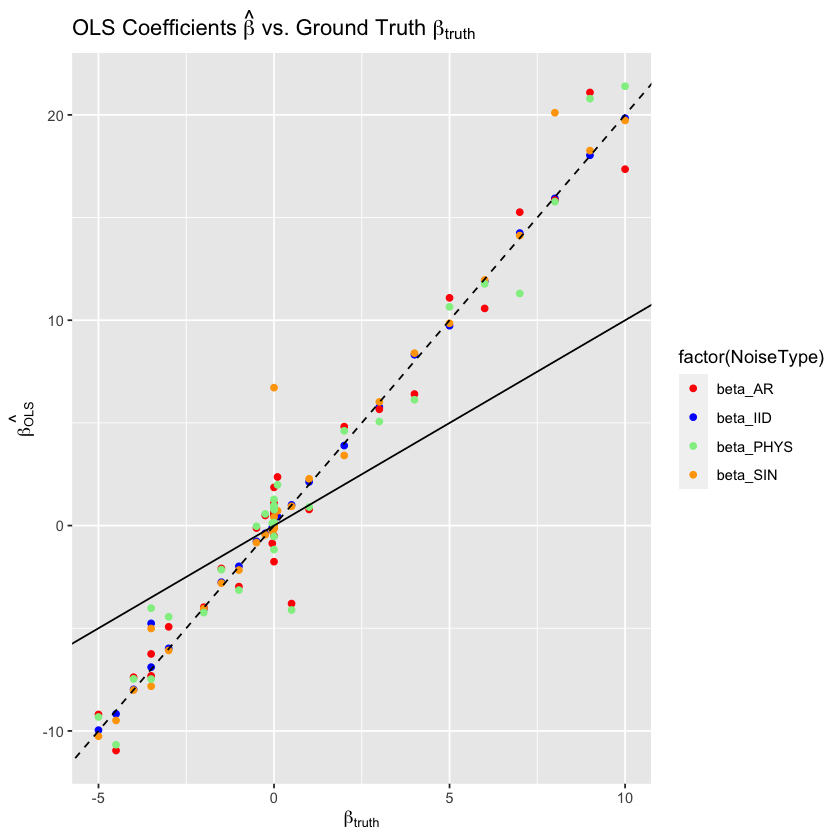

In [239]:
library(latex2exp)

ggplot(data = df2, aes(x = TRUTH, y = beta, color = factor(NoiseType))) +
    geom_point() +
    scale_color_manual(values=c("red","blue","lightgreen","orange"))+
    xlab(TeX("$\\beta_{truth}$"))+
    ylab(TeX("$\\hat{\\beta_{OLS}}$"))+
    ggtitle(TeX("OLS Coefficients $\\hat{\\beta}$ vs. Ground Truth $\\beta_{truth}$"))+
    geom_abline(intercept = 0, slope = 1)+
    geom_abline(intercept = 0, slope = 2,linetype=2)

#### OLS Thoughts:

Interesting. First, results are not "as bad" as I expected. Sure, there's a factor of 2 missing somewhere (dotted line slope=2), but on the whole, I'm impressed with how consistent OLS recovers truth. That said, it's a long experiment at 2h. This is great motivation for the rest of the exploration: generalized linear model (AR-IRLS), bootstrapping, and power analysis!

In [230]:
nirs_arirls <- function(dat) {
    
    X <- dat[,33:64]

    Y <- dat[,1:32]
    
    numvar = ncol(Y)
    
    beta <- matrix(0,nrow=numvar) 
    
    for (i in 1:numvar) {
        
        fit <- lm(Y[,i] ~ X[,i])
        
        beta[i,] <- coef(fit)[2]
   }
    
    return(data.fram_e(beta))
}

beta_TRUTH <- c(0.1,-0.05,0.5,-0.25,1,-0.5,2,-1,3,-1.5,4,-2,5,-3.5,6,-3,7,-3.5,8,-4,9,-4.5,10,-5,0,0,0,0,0,0,0,0)

beta_iid_resid <- nirs_ols(nirs_iid_resid)
beta_ar_resid <- nirs_ols(nirs_ar_resid)
beta_sin_resid <- nirs_ols(nirs_sin_resid)
beta_phys_resid <- nirs_ols(nirs_phys_resid)

idx = 1:nrow(beta_iid_resid)
dat2 <- data.frame(idx,beta_TRUTH,beta_iid_resid,beta_ar_resid,beta_sin_resid,beta_phys_resid)
colnames(dat2) <- c('idx','beta_TRUTH','beta_IID_resid','beta_AR_resid','beta_SIN_resid','beta_PHYS_resid')
dat2

idx,beta_TRUTH,beta_IID_resid,beta_AR_resid,beta_SIN_resid,beta_PHYS_resid
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.10,0.212994649,1.02239314,0.07713768,2.4026404
2,-0.05,-0.079330886,-1.25096886,-0.59103946,0.1518820
3,0.50,0.994297978,-3.31385563,0.72787363,-3.7641220
4,-0.25,-0.416995227,0.14322218,-0.88205146,1.4180926
5,1.00,2.137318421,-2.44282320,3.07257000,1.5577406
6,-0.50,-0.860606649,-0.03169622,-1.63472337,0.2942612
7,2.00,4.065252276,2.93527272,3.87754979,4.9253714
8,-1.00,-2.121840376,-3.27505782,-3.10584488,-2.9055570
9,3.00,6.071983485,7.78765029,7.06759513,3.3497259


,idx,NoiseType,beta
,<int>,<chr>,<dbl>
1,1,beta_TRUTH,0.10
2,2,beta_TRUTH,-0.05
3,3,beta_TRUTH,0.50
4,4,beta_TRUTH,-0.25
5,5,beta_TRUTH,1.00
6,6,beta_TRUTH,-0.50


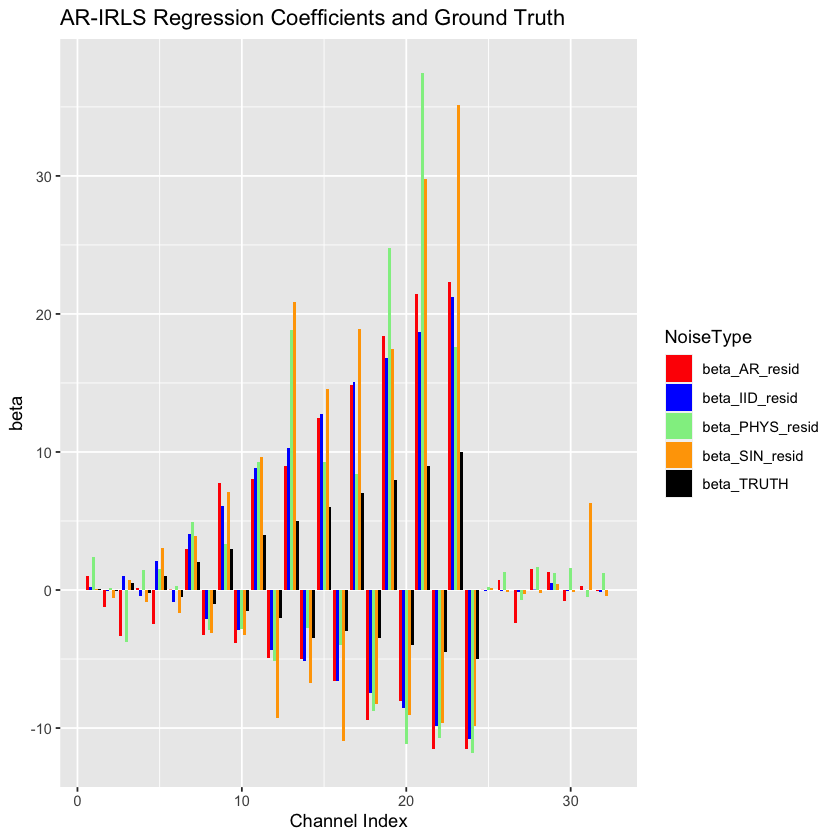

In [231]:
df3 <- gather(dat2, key="NoiseType", value="beta", 2:6)
head(df3)

ggplot(data = df3, aes(x = idx, y = beta, fill = NoiseType)) +
    geom_col(position="dodge") +
    scale_fill_manual(values=c("red","blue","lightgreen","orange","black"))+
    xlab("Channel Index")+
    ggtitle("AR-IRLS Regression Coefficients and Ground Truth")

In [232]:
colnames(dat2)[2] <- c('TRUTH')
df4 <- gather(dat2, key="NoiseType", value="beta", 3:6)
head(df4)

,idx,TRUTH,NoiseType,beta
,<int>,<dbl>,<chr>,<dbl>
1,1,0.10,beta_IID_resid,0.21299465
2,2,-0.05,beta_IID_resid,-0.07933089
3,3,0.50,beta_IID_resid,0.99429798
4,4,-0.25,beta_IID_resid,-0.41699523
5,5,1.00,beta_IID_resid,2.13731842
6,6,-0.50,beta_IID_resid,-0.86060665


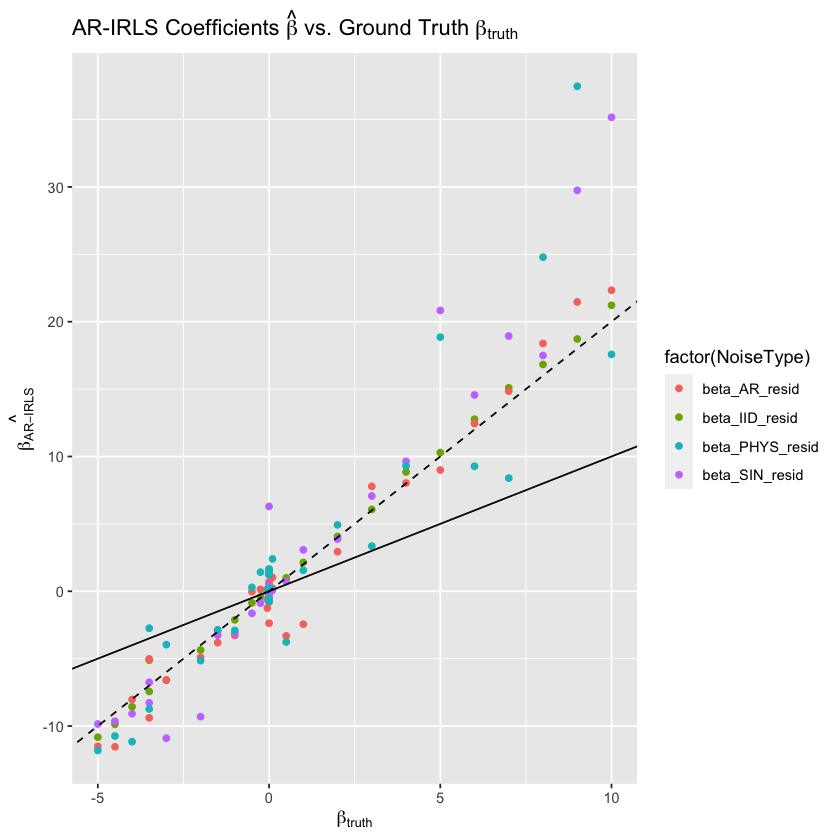

In [233]:
library(latex2exp)

ggplot(data = df4, aes(x = TRUTH, y = beta, color = factor(NoiseType))) +
    geom_point() +
    scale_fill_manual(values=c("red","blue","lightgreen","orange"))+
    xlab(TeX("$\\beta_{truth}$"))+
    ylab(TeX("$\\hat{\\beta_{AR-IRLS}}$"))+
    ggtitle(TeX("AR-IRLS Coefficients $\\hat{\\beta}$ vs. Ground Truth $\\beta_{truth}$"))+
    geom_abline(intercept = 0, slope = 1)+
    geom_abline(intercept = 0, slope = 2,linetype=2)

#### AR-IRLS Thoughts:

Also interesting. I sat here for an hour trying to think of a compelling way of plotting OLS vs. AR-IRLS, but given these data are one-off simulations and vary about the same slopes, I think it's safe to say both regression methods recover ground truth in more or less the same fashion. This is especially interesting in the case of OLS, where I thought the model violations (autocorrelation and heavy-taildness) would ruin the fit. Of course, I didn't pull standard error so the p-values may be different between the two models, but I don't wan't to go down that route...

My hypothesis, that 1. "for a given `beta`, the magnitude of our regression coefficients will decrease as complexity of the noise increases $\beta_{IID} > \beta_{SIN} > \beta_{AR(5)} > \beta_{PHYS}$." Well, it certainly doesn't follow that trend. Nor does it follow hypothesis 2, "or a given noise type, as beta increases, we see decreases to our regression coefficients and corresponding p-values, but crucially, this mapping is not one-to-one. That is, if beta increases by 1, this will not yield a regression coefficient increase by 1."

So there's a scale factor of 2 missing somewhere, but `beta` does indeed hold a 1-to-1 relationship with OLS solutions...if you're keeping score at home, that's Ted one, Tim nil.

I'm going to make the executive decision to only run the bootstrapping and power analysis on OLS, even though I know doing OLS on a time series like this is a bit of a faux pas for reasons just stated

---
### Class Method 2: Bootstrapping Regression Coefficients

Let's bootstrap the beta values. Since we know the relationship between the OLS coefficients and `beta` (truth) is linear (but 2x what it should be), and that $\beta_{HbR}$ is $-\frac{\beta_{Hb0}}{2}$, I'll plot the bootstrap results at channels 1, 5, 13 and 23 (HbO, SNR = 0.1, 1.0, 5.0, and 10.0).

In [244]:
#install.packages("ISLR")
library(ISLR)
library(boot)

In [275]:
boot.fn <- function(data, index){
    
    X <- data[,5]

    Y <- data[,1:4]
    
    numvar = ncol(Y)
    
    beta <- matrix(0,nrow=numvar) 
    
    for (i in 1:numvar) {
        
        fit <- lm(Y[,i] ~ X ,subset=index)
        
        beta[i,] <- coef(fit)[2]
   }
    
    return(beta)
}

In [276]:
nirs_iid = nirs_iid_raw[,c(1,5,13,23,33)]
nirs_ar = nirs_ar_raw[,c(1,5,13,23,33)]
nirs_sin = nirs_sin_raw[,c(1,5,13,23,33)]
nirs_phys = nirs_phys_raw[,c(1,5,13,23,33)]

boot_iid = boot(nirs_iid ,boot.fn ,R=1000) #R=repetitions 
boot_ar = boot(nirs_ar ,boot.fn ,R=1000) #R=repetitions 
boot_sin = boot(nirs_sin ,boot.fn ,R=1000) #R=repetitions 
boot_phys = boot(nirs_phys ,boot.fn ,R=1000) #R=repetitions 

boot_iid


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = nirs_iid, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
      original       bias    std. error
t1*  0.4367736  0.015162287   0.2791298
t2*  2.1273331  0.018214834   0.2625472
t3*  9.7321792 -0.007872234   0.2791426
t4* 19.8400313 -0.015585646   0.2744800

In [320]:
boot_iid$t0

0.4367736
2.1273331
9.7321792
19.8400313


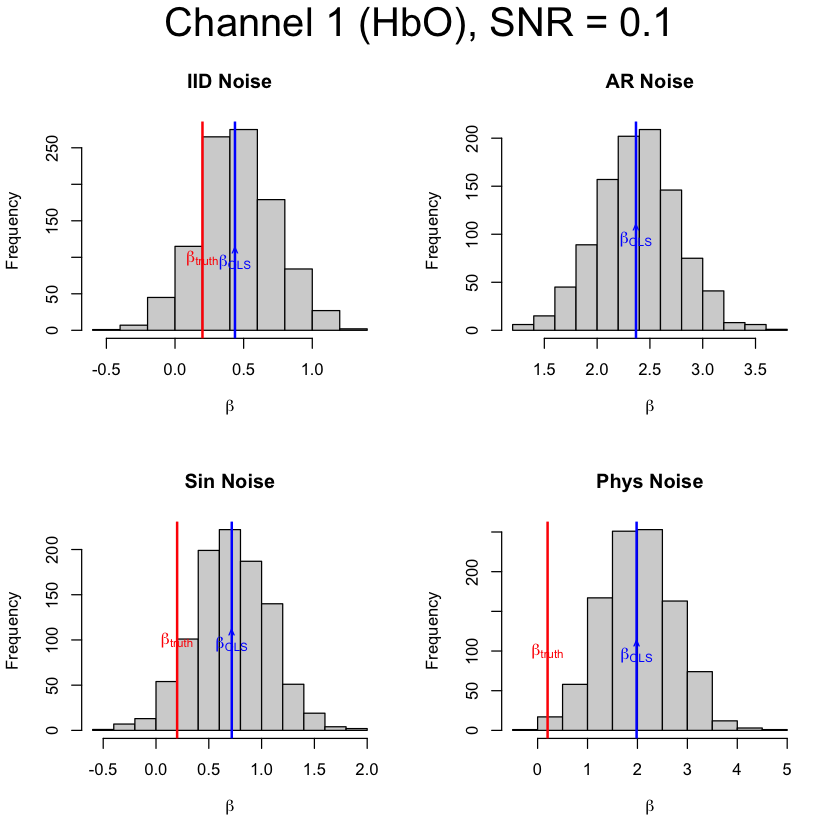

In [336]:
par(mfrow=c(2,2),oma=c(0,0,2,0))

hist(boot_iid$t[,1],xlab=TeX("$\\beta$"),main="IID Noise")
abline(v=beta_iid_raw[1,],col="blue",lwd=2)
text(beta_iid_raw[1,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[1]*2),col="red",lwd=2)
text(beta_TRUTH[1]*2, 100, TeX("$\\beta_{truth}$"),col="red")

hist(boot_ar$t[,1],xlab=TeX("$\\beta$"),main="AR Noise")
abline(v=beta_ar_raw[1,],col="blue",lwd=2)
text(beta_ar_raw[1,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[1]*2),col="red",lwd=2)
text(beta_TRUTH[1]*2, 100, TeX("$\\beta_{truth}$"),col="red")

hist(boot_sin$t[,1],xlab=TeX("$\\beta$"),main="Sin Noise")
abline(v=beta_sin_raw[1,],col="blue",lwd=2)
text(beta_sin_raw[1,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[1]*2),col="red",lwd=2)
text(beta_TRUTH[1]*2, 100, TeX("$\\beta_{truth}$"),col="red")

hist(boot_phys$t[,1],xlab=TeX("$\\beta$"),main="Phys Noise")
abline(v=beta_phys_raw[1,],col="blue",lwd=2)
text(beta_phys_raw[1,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[1]*2),col="red",lwd=2)
text(beta_TRUTH[1]*2, 100, TeX("$\\beta_{truth}$"),col="red")

mtext("Channel 1 (HbO), SNR = 0.1", line=0, side=3, outer=TRUE, cex=2)

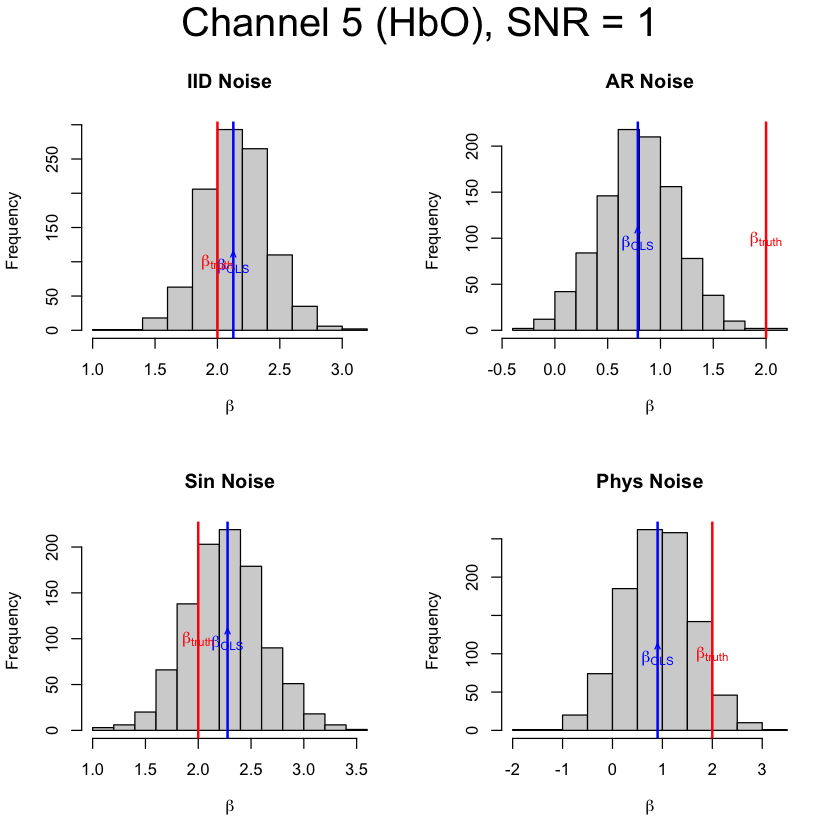

In [332]:
par(mfrow=c(2,2),oma=c(0,0,2,0))

hist(boot_iid$t[,2],xlab=TeX("$\\beta$"),main="IID Noise")
abline(v=beta_iid_raw[5,],col="blue",lwd=2)
text(beta_iid_raw[5,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[5]*2),col="red",lwd=2)
text(beta_TRUTH[5]*2, 100, TeX("$\\beta_{truth}$"),col="red")

hist(boot_ar$t[,2],xlab=TeX("$\\beta$"),main="AR Noise")
abline(v=beta_ar_raw[5,],col="blue",lwd=2)
text(beta_ar_raw[5,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[5]*2),col="red",lwd=2)
text(beta_TRUTH[5]*2, 100, TeX("$\\beta_{truth}$"),col="red")

hist(boot_sin$t[,2],xlab=TeX("$\\beta$"),main="Sin Noise")
abline(v=beta_sin_raw[5,],col="blue",lwd=2)
text(beta_sin_raw[5,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[5]*2),col="red",lwd=2)
text(beta_TRUTH[5]*2, 100, TeX("$\\beta_{truth}$"),col="red")

hist(boot_phys$t[,2],xlab=TeX("$\\beta$"),main="Phys Noise")
abline(v=beta_phys_raw[5,],col="blue",lwd=2)
text(beta_phys_raw[5,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[5]*2),col="red",lwd=2)
text(beta_TRUTH[5]*2, 100, TeX("$\\beta_{truth}$"),col="red")

mtext("Channel 5 (HbO), SNR = 1", line=0, side=3, outer=TRUE, cex=2)

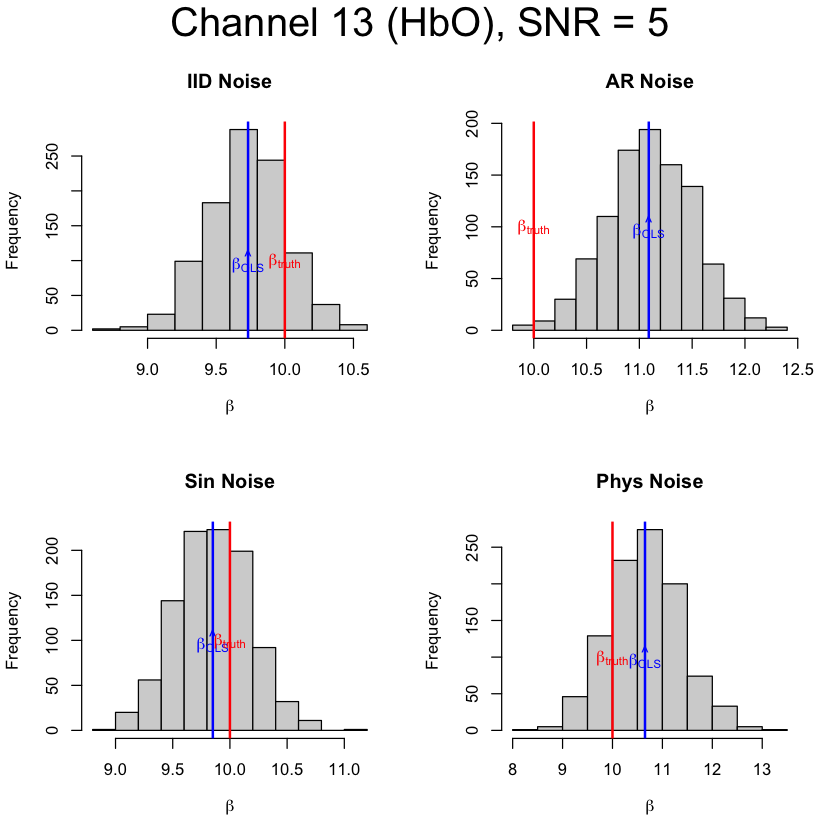

In [334]:
par(mfrow=c(2,2),oma=c(0,0,2,0))

hist(boot_iid$t[,3],xlab=TeX("$\\beta$"),main="IID Noise")
abline(v=beta_iid_raw[13,],col="blue",lwd=2)
text(beta_iid_raw[13,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[13]*2),col="red",lwd=2)
text(beta_TRUTH[13]*2, 100, TeX("$\\beta_{truth}$"),col="red")

hist(boot_ar$t[,3],xlab=TeX("$\\beta$"),main="AR Noise")
abline(v=beta_ar_raw[13,],col="blue",lwd=2)
text(beta_ar_raw[13,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[13]*2),col="red",lwd=2)
text(beta_TRUTH[13]*2, 100, TeX("$\\beta_{truth}$"),col="red")

hist(boot_sin$t[,3],xlab=TeX("$\\beta$"),main="Sin Noise")
abline(v=beta_sin_raw[13,],col="blue",lwd=2)
text(beta_sin_raw[13,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[13]*2),col="red",lwd=2)
text(beta_TRUTH[13]*2, 100, TeX("$\\beta_{truth}$"),col="red")

hist(boot_phys$t[,3],xlab=TeX("$\\beta$"),main="Phys Noise")
abline(v=beta_phys_raw[13,],col="blue",lwd=2)
text(beta_phys_raw[13,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[13]*2),col="red",lwd=2)
text(beta_TRUTH[13]*2, 100, TeX("$\\beta_{truth}$"),col="red")

mtext("Channel 13 (HbO), SNR = 5", line=0, side=3, outer=TRUE, cex=2)

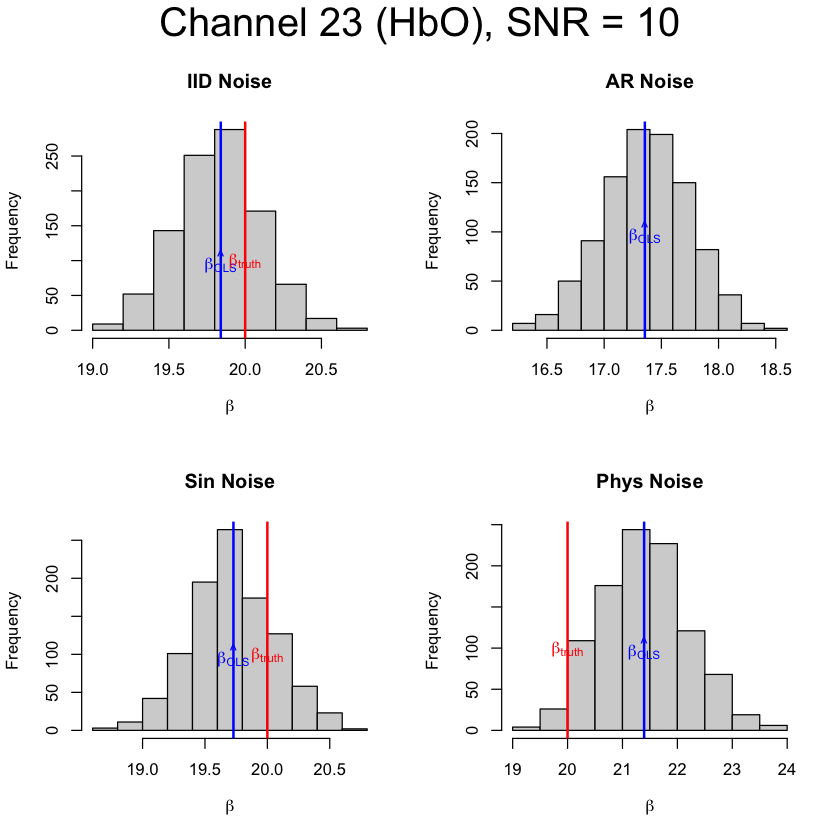

In [335]:
par(mfrow=c(2,2),oma=c(0,0,2,0))

hist(boot_iid$t[,4],xlab=TeX("$\\beta$"),main="IID Noise")
abline(v=beta_iid_raw[23,],col="blue",lwd=2)
text(beta_iid_raw[23,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[23]*2),col="red",lwd=2)
text(beta_TRUTH[23]*2, 100, TeX("$\\beta_{truth}$"),col="red")

hist(boot_ar$t[,4],xlab=TeX("$\\beta$"),main="AR Noise")
abline(v=beta_ar_raw[23,],col="blue",lwd=2)
text(beta_ar_raw[23,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[23]*2),col="red",lwd=2)
text(beta_TRUTH[23]*2, 100, TeX("$\\beta_{truth}$"),col="red")

hist(boot_sin$t[,4],xlab=TeX("$\\beta$"),main="Sin Noise")
abline(v=beta_sin_raw[23,],col="blue",lwd=2)
text(beta_sin_raw[23,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[23]*2),col="red",lwd=2)
text(beta_TRUTH[23]*2, 100, TeX("$\\beta_{truth}$"),col="red")

hist(boot_phys$t[,4],xlab=TeX("$\\beta$"),main="Phys Noise")
abline(v=beta_phys_raw[23,],col="blue",lwd=2)
text(beta_phys_raw[23,], 100, TeX("$\\hat{\\beta_{OLS}}$"),col="blue")
abline(v=(beta_TRUTH[23]*2),col="red",lwd=2)
text(beta_TRUTH[23]*2, 100, TeX("$\\beta_{truth}$"),col="red")

mtext("Channel 23 (HbO), SNR = 10", line=0, side=3, outer=TRUE, cex=2)

Assume we found that scale factor of 2 in the *nirs toolbox*, so we double it in the above plots. The first thing that stands out is OLS performs "worst" on the AR data (go figure), in that the average and results of the bootstrap are consistently the farthest away relative to the distributions (though obviously scale plays a role here). The bootstraps are centered over the original simulations' means, which is always a good thing. There's no real rhyme or reason to how the other three noise types are distributed around the true `beta`.

---
### Class Method 3: Power Analysis

For continuity, we'll run the power analysis on the same four indices, channels 1, 5, 13 and 23 (HbO, SNR = 0.1, 1.0, 5.0, and 10.0). For simplicity, we'll assume the residual standard error to be equal amongst the two conditions (baseline vs. task). Assuming the (final) results for these channels are true, how long *would* we have needed to run for sufficient coverage?

In [381]:
run_analysis <- function(data) {
    fit <- t.test(data[,1], data[,2])
    return(c(fit$estimate[1] - fit$estimate[2],fit$stderr,fit$p.value)) # this outputs the effect size, standard error, and significance for quality metrics 
}

In [394]:
df = nirs_iid_raw[,c(1,33)]
f = lm(df[,1]~df[,2])

mu_off_iid_1=f$coefficients[1]
mu_on_iid_1=f$coefficients[1]+f$coefficients[2]

k=length(f$coefficients)-1 #Subtract one to ignore intercept
SSE=sum(f$residuals**2)
n=length(f$residuals)
sd_off_iid_1= sqrt(SSE/(n-(1+k))) 

In [389]:
simulate_data <- function(t, group1_mu, group2_mu, sd) {
    # draw observation from a normal distribution
    obs_group1 <- rnorm(t, group1_mu, sd)
    obs_group2 <- rnorm(t, group2_mu, sd)
    return(data.frame(group1=obs_group1, group2=obs_group2))
}

repeat_analysis <- function(n_simulations, alpha, t, group1_mu, group2_mu, sd) {
    simouts <- matrix(rep(NA,n_simulations*3),nrow=n_simulations,ncol=3) # empty vector to store ests, stderr, p-values from each simulation
    
    # loop for repeating the simulation
    for (i in 1:n_simulations) {
        data <- simulate_data(t, group1_mu, group2_mu, sd) # simulate the data using the defined function
        simouts[i,] <- run_analysis(data) # run the analysis, and add outputs to the matrix
    }
    
    # calculate coverage (AKA power)
    cvg <- mean(simouts[,3] <= alpha) # this is the same as the number of sims that successfully rejected null divided by total number of sims - probability of correctly rejecting the null!
    # calculate relative parameter estimate bias
    theta_bias <- ( mean(simouts[,1]) - (group1_mu-group2_mu) ) / (group1_mu-group2_mu)
    # calculate relative standard error bias 
    sigma_bias <- (mean(simouts[,2]) - sd(simouts[,1])) / sd(simouts[,1])

    return(list(cvg = cvg, theta_bias=theta_bias, sigma_bias=sigma_bias, p.values=simouts[,3])) #return a list with the power as the probability of a sig. result and the corresponding p-values
}

In [414]:
set.seed(040819)
#sd = simulate_data(t = 1000,group1_mu=mu_off_iid_1, group2_mu = mu_on_iid_1, sd = sd_off_iid_1)

results <- matrix(NA,nrow=5,ncol=4)
for (i in c(1,5,13,23)) {
    for (t in c(10,100,1000,10000,100000)) {
        if (i==1) {i_step=1}
        if (t==10) {t_step=1}
        
        f = lm(nirs_iid_raw[,i_step]~nirs_iid_raw[,33])
        
        mu_off_iid_1=f$coefficients[1]
        mu_on_iid_1=f$coefficients[1]+f$coefficients[2]

        k=length(f$coefficients)-1 #Subtract one to ignore intercept
        SSE=sum(f$residuals**2)
        n=length(f$residuals)
        sd_off_iid_1= sqrt(SSE/(n-(1+k))) 
        
        result = repeat_analysis(n_simulations = 1000, alpha = 0.05, t = t,
                          group1_mu=mu_off_iid_1, group2_mu = mu_on_iid_1, sd = sd_off_iid_1)

        results[t_step,i_step]=as.numeric(result[1])
        t_step=t_step+1
    } 
    i_step=i_step+1
}
results

0.055,0.048,0.062,0.061
0.043,0.050,0.059,0.063
0.058,0.042,0.137,0.099
0.191,0.065,0.692,0.499
0.923,0.278,1.000,1.000


In [415]:
out = data.frame(c(10,100,1000,10000,100000),results)
colnames(out)[1]= c('t')
out

t,X1,X2,X3,X4
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1e+01,0.055,0.048,0.062,0.061
1e+02,0.043,0.050,0.059,0.063
1e+03,0.058,0.042,0.137,0.099
1e+04,0.191,0.065,0.692,0.499
1e+05,0.923,0.278,1.000,1.000


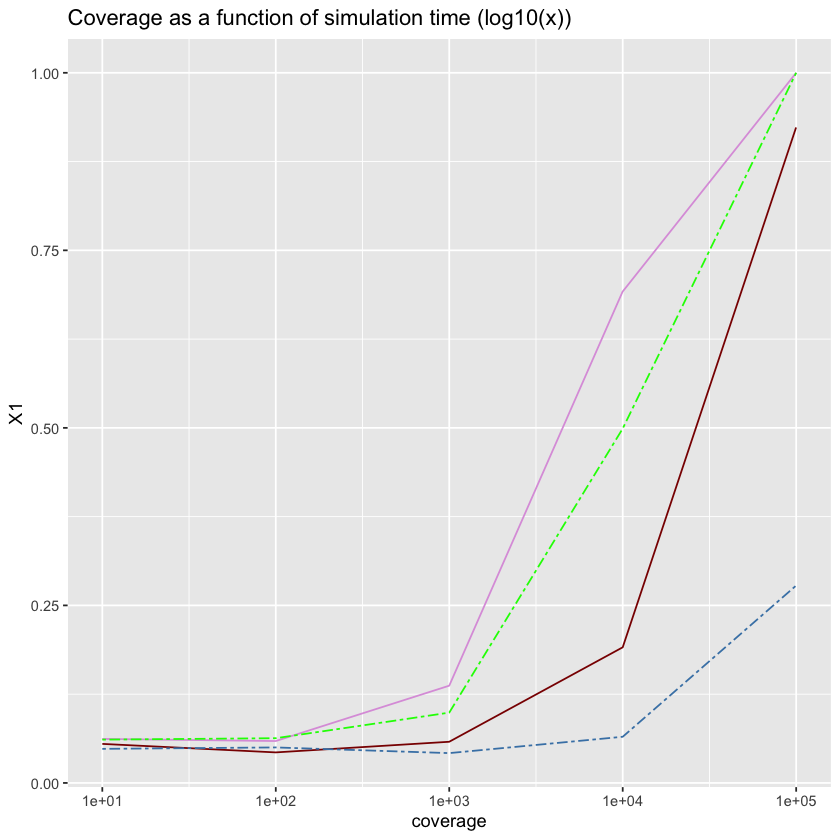

In [429]:

ggplot(out, aes(x=t)) + 
  geom_line(aes(y = X1), color = "darkred") + 
  geom_line(aes(y = X2), color="steelblue", linetype="twodash") +
  geom_line(aes(y = X3), color = "plum") + 
  geom_line(aes(y = X4), color="green", linetype="twodash") +
  scale_x_continuous(trans='log10')+
  xlab("coverage")+
labs(title=("Coverage as a function of simulation time (log10(x))"))

Coverage is indeed inversely proportional to beta...so we confirmed my last hypothesis. If I had more time, I would do a finer-grained plot of this data across all 32 channels, and for more *t*, but I'm runnning late as-is, and these types of simulations by nature take the longest, and an exponential $t$ doesn't help. Of course, we have to remember the assumptions we made to get these power analysis values: task and baseline have the same standard deviation, and the fact that this is time-series doesn't matter.

I couldn't get a legend to plot in a timely manner, but see the code for the lines and their corresponfing betas. 

---
## 7. Conclusions

I had a really fun time with this exploration. Ted, as it turns out, did his homework on the toolbox better than I originally gave him credit for! That said, we may have found a bug in out toolbox, so that's cool. This will be a great reference in the future, as I plan to flesh out ths whole idea of fNIRS power analysis.

---
## References

1. Steinbrink, J. et al., “Illuminating the BOLD signal: combined fMRI-fNIRS studies,” *Magn. Reson. Imaging* 24(4), 495–505 (2006).

2. Friston, K. et al., "Statistical Parametric Mapping," *Academic Press* (2007).

3. Santosa, H., Zhai, X., Fishburn, F., Huppert, T. "The NIRS Brain AnalyzIR Toolbox," *Algorithms* 11, 73 (2018).

4. Barker, J., Aarabi, A., Huppert, T. "Autoregressive model based algorithm for correcting motion and serially correlated errors in fNIRS" *Biomedical Optics Express* (2013).